In [2]:
import os
import pandas as pd

In [3]:
data = pd.read_pickle('data/LSWMD.pkl')
data.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


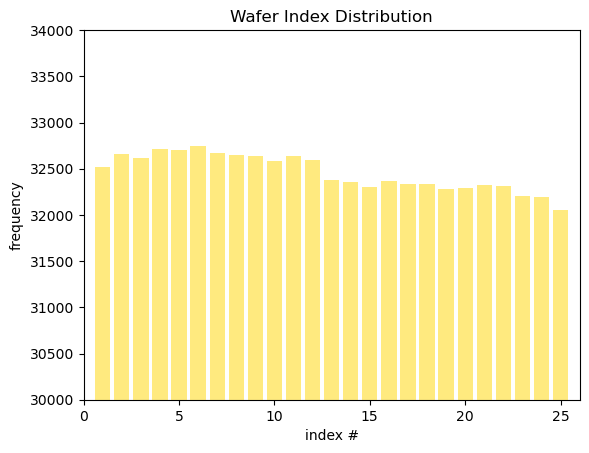

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

uni_index = np.unique(data.waferIndex, return_counts=True )
plt.bar(uni_index[0], uni_index[1], color='gold', align='center', alpha=0.5)
plt.title('Wafer Index Distribution')
plt.xlabel('index #')
plt.ylabel('frequency')
plt.xlim(0, 26)
plt.ylim(30000, 34000)
plt.show()

In [6]:
data = data.drop(['waferIndex'], axis = 1)

In [7]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
data['waferMapDim']=data.waferMap.apply(find_dim)
data.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
478737,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot29618,[],[],"(49, 39)"
164720,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1461.0,lot10553,[],[],"(42, 45)"
252666,"[[0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 0, 0,...",260.0,lot15660,[],[],"(18, 19)"
123572,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",515.0,lot8211,[],[],"(25, 27)"
238706,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4553.0,lot14879,[],[],"(73, 79)"


In [8]:
print(max(data.waferMapDim), min(data.waferMapDim))
uni_waferDim=np.unique(data.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]

(300, 202) (6, 21)


632